# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.624872,True,6.597641
1,-0.053984,True,6.226814
2,-0.014034,True,3.678794
3,-2.005407,False,0.135829
4,-1.562907,True,3.737552
...,...,...,...
995,-0.723923,False,-0.584151
996,-0.174778,True,5.003410
997,0.462466,True,4.345259
998,0.793546,True,6.243609


<AxesSubplot: xlabel='v0'>

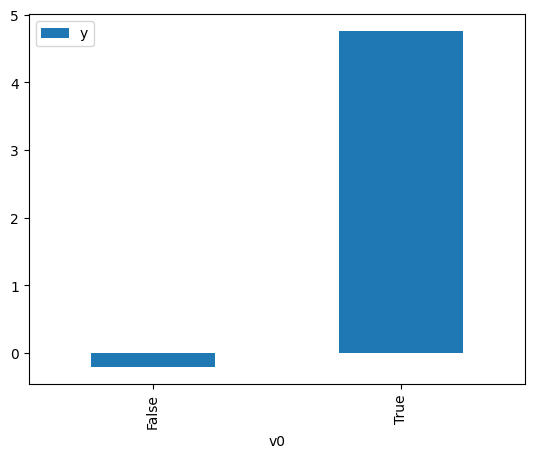

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

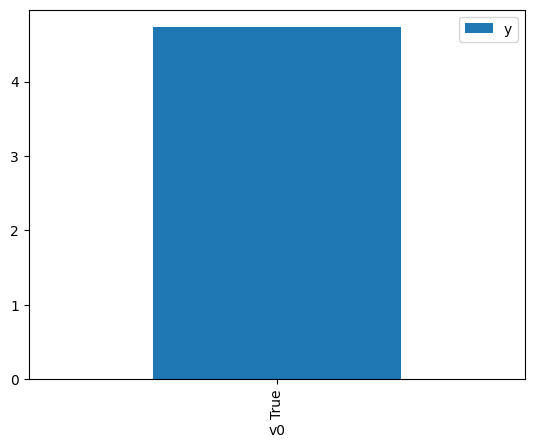

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.672704,False,2.825272,0.141113,7.086523
1,-0.481830,False,0.779423,0.637168,1.569445
2,-0.032865,False,-0.012087,0.517344,1.932952
3,0.057448,False,0.780792,0.492524,2.030360
4,-0.471893,False,-0.323118,0.634638,1.575701
...,...,...,...,...,...
995,0.260015,False,1.114671,0.437170,2.287439
996,-1.240531,False,-2.232898,0.801767,1.247245
997,1.029813,False,1.059657,0.249901,4.001585
998,-0.785371,False,-0.967826,0.710307,1.407843


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.582254,True,4.907711,0.647255,1.544986
1,-0.332369,True,3.684002,0.401614,2.489951
2,-0.631366,True,4.129466,0.325738,3.069952
3,-1.058861,True,3.965716,0.231901,4.312186
4,-1.196271,True,3.783799,0.206082,4.852440
...,...,...,...,...,...
995,-0.668406,True,3.220468,0.316857,3.156002
996,0.551732,True,6.272883,0.639555,1.563588
997,-0.539608,True,4.717390,0.348276,2.871287
998,-0.621763,True,4.197982,0.328062,3.048209


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.939
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7665.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:15:49   Log-Likelihood:                         -1408.6
No. Observations:                1000   AIC:                                      2821.
Df Residuals:                     998   BIC:                                      2831.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3326      0.032     41.457      0.000       1.270       1.396
x2             5.0118      0.047    105.759      0.000       4.919       5.105
==============================================================================
Omnibus:                        0.990   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.610   Jarque-Bera (JB):                1.071
Skew:                          -0.057   Prob(JB):                        0.585
Kurtosis:                       2.887   Cond. No.                         1.56
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""